<a href="https://colab.research.google.com/github/Blecyrajan/ML_Projects/blob/main/Brain_Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Environment & Kaggle Data Setup**

In [8]:
import kagglehub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.


**Data Preprocessing & Augmentation**

In [9]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Standards for Research
IMAGE_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('/kaggle/input/brain-tumor-mri-dataset/Training', transform=transform)
test_dataset = datasets.ImageFolder('/kaggle/input/brain-tumor-mri-dataset/Testing', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

classes = train_dataset.classes
print(f"Classes: {classes}")


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


**The Hybrid CNN-ViT Architecture**

In [10]:
import torch.nn as nn
import timm

class BrainTumorModel(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # CNN: ResNet18 for local texture
        self.cnn = timm.create_model('resnet18', pretrained=True, features_only=True)
        # ViT: Tiny Vision Transformer for global context
        self.vit = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=0)

        # Fusion Layer
        self.classifier = nn.Linear(512 + 192, num_classes)

    def forward(self, x):
        # 1. Get CNN Features
        cnn_maps = self.cnn(x)[-1] # [B, 512, 7, 7]
        cnn_feat = torch.mean(cnn_maps, dim=(2, 3)) # Global Average Pool

        # 2. Get ViT Features
        vit_feat = self.vit(x) # [B, 192]

        # 3. Combine
        combined = torch.cat((cnn_feat, vit_feat), dim=1)
        logits = self.classifier(combined)

        return logits, cnn_maps # Maps used for RSC Loss & Intrinsic Heatmaps


**RSC Loss & Training Logic**

In [11]:
def rsc_loss_fn(feat_orig, feat_flipped):
    # Intrinsic Explanation Map Generation
    map_orig = torch.mean(feat_orig, dim=1)
    map_flipped = torch.mean(feat_flipped, dim=1)
    map_flipped_restored = torch.flip(map_flipped, dims=[2])
    return nn.functional.mse_loss(map_orig, map_flipped_restored)

# Training Settings
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BrainTumorModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) # AdamW is better for ViT
criterion = nn.CrossEntropyLoss()

# Training Loop
def train_model(epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward Original
            logits, feat_orig = model(images)
            # Forward Flipped (for Consistency)
            _, feat_flipped = model(torch.flip(images, dims=[-1])) # Assuming images are [B, C, H, W], flip along W

            # Weighted Loss
            loss_cls = criterion(logits, labels)
            loss_rsc = rsc_loss_fn(feat_orig, feat_flipped)
            total_loss = loss_cls + (0.5 * loss_rsc)

            total_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += total_loss.item()

        print(f"Epoch {epoch+1} | Loss: {train_loss/len(train_loader):.4f}")

train_model(epochs=10) # Increase epochs for better accuracy

Epoch 1 | Loss: 0.2579
Epoch 2 | Loss: 0.0628
Epoch 3 | Loss: 0.0342
Epoch 4 | Loss: 0.0192
Epoch 5 | Loss: 0.0354
Epoch 6 | Loss: 0.0224
Epoch 7 | Loss: 0.0317
Epoch 8 | Loss: 0.0071
Epoch 9 | Loss: 0.0032
Epoch 10 | Loss: 0.0006


**Scientific Evaluation & Plotting**

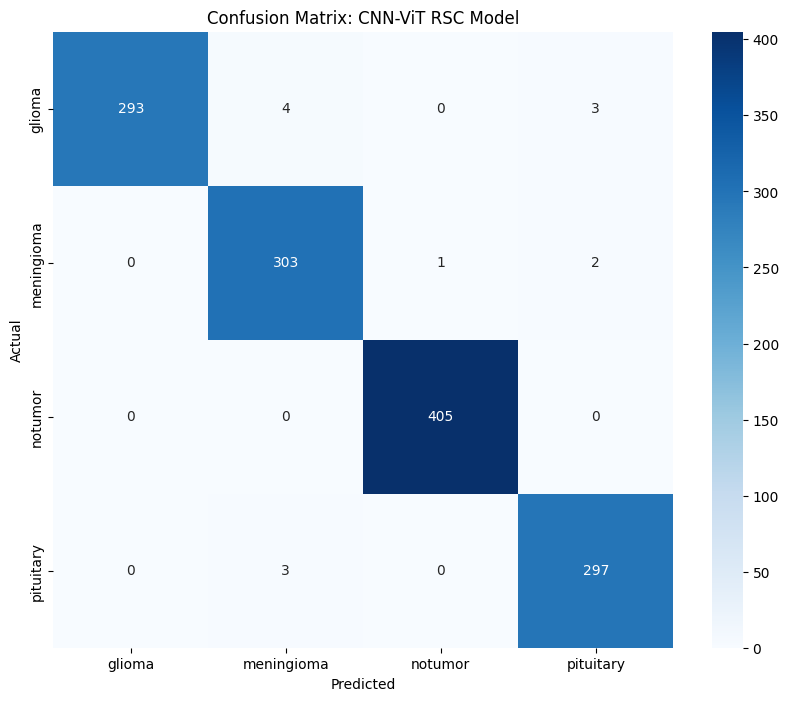

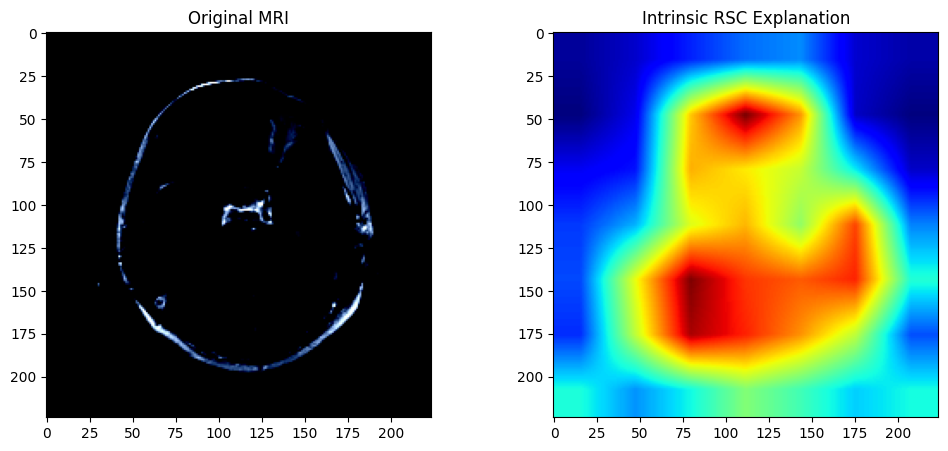

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2

def evaluate_and_save_plots():
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out, _ = model(imgs)
            preds.extend(out.argmax(1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    # 1. Confusion Matrix Plot
    plt.figure(figsize=(10,8))
    cm = confusion_matrix(targets, preds)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix: CNN-ViT RSC Model')
    plt.savefig('confusion_matrix.png')
    plt.show()

    # 2. Intrinsic Heatmap Plot (The Explanation for your App)
    sample_img, _ = test_dataset[10] # Pick a sample
    logits, maps = model(sample_img.unsqueeze(0).to(device))

    # Process heatmap from the internal learned layer
    heatmap = torch.mean(maps, dim=1).squeeze().cpu().detach().numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    heatmap = cv2.resize(heatmap, (224, 224))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(sample_img.permute(1, 2, 0).cpu())
    plt.title("Original MRI")

    plt.subplot(1, 2, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Intrinsic RSC Explanation")
    plt.savefig("explanation_results.png")
    plt.show()

evaluate_and_save_plots()

**Saving for Production**

In [14]:
# Save the entire model (weights and architecture)
torch.save(model.state_dict(), 'brain_tumor_rsc_model.pth')

# To load in Backend:
# model = BrainTumorModel()
# model.load_state_dict(torch.load('brain_tumor_rsc_model.pth'))
# model.eval()


**Dataset Distribution & Sample Visualization**

/tmp/ipython-input-387582112.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dataset.classes, y=class_counts, palette="magma")


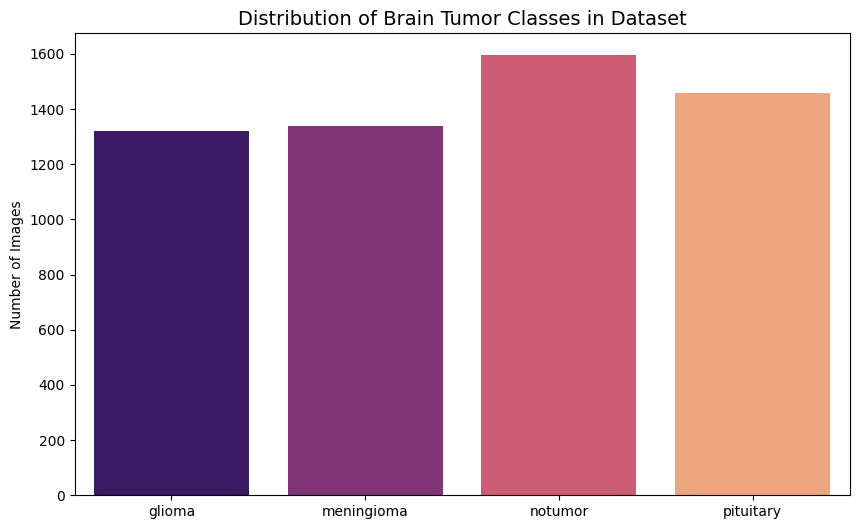

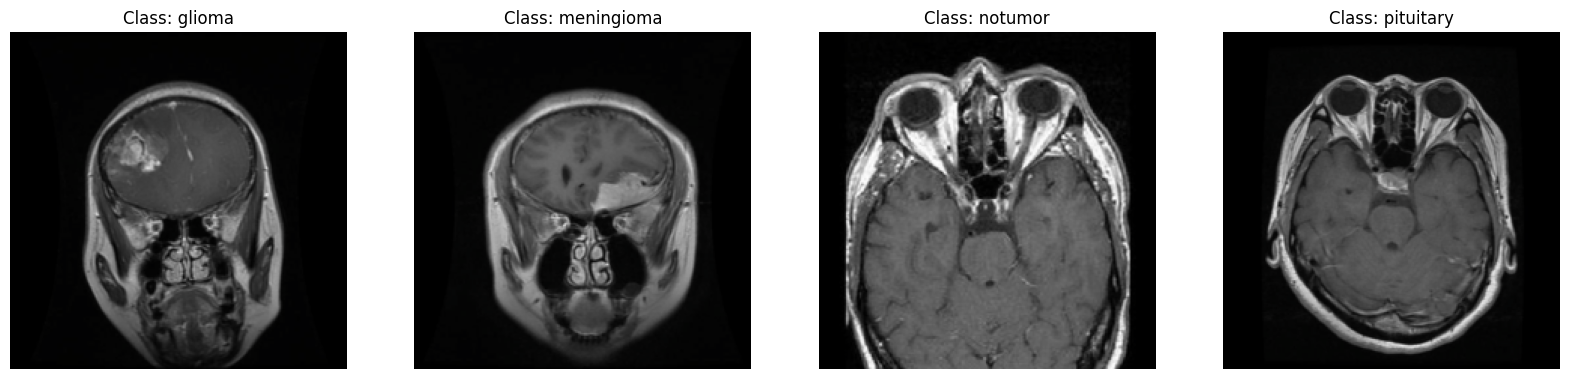

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# --- Plot A: Dataset Distribution ---
def plot_dataset_summary(dataset):
    targets = np.array(dataset.targets)
    class_counts = [np.sum(targets == i) for i in range(len(dataset.classes))]

    plt.figure(figsize=(10, 6), dpi=100)
    sns.barplot(x=dataset.classes, y=class_counts, palette="magma")
    plt.title("Distribution of Brain Tumor Classes in Dataset", fontsize=14)
    plt.ylabel("Number of Images")
    plt.savefig("figure_1_distribution.png", bbox_inches='tight')
    plt.show()

# --- Plot B: Samples from Each Class ---
def plot_class_samples(dataset):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for i, class_name in enumerate(dataset.classes):
        # Find first index of this class
        idx = dataset.targets.index(i)
        img, _ = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        # Un-normalize for display
        img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        axes[i].imshow(np.clip(img, 0, 1))
        axes[i].set_title(f"Class: {class_name}", fontsize=12)
        axes[i].axis('off')
    plt.savefig("figure_2_samples.png")
    plt.show()

plot_dataset_summary(train_dataset)
plot_class_samples(train_dataset)


**Preprocessing Analysis (Before & After)**

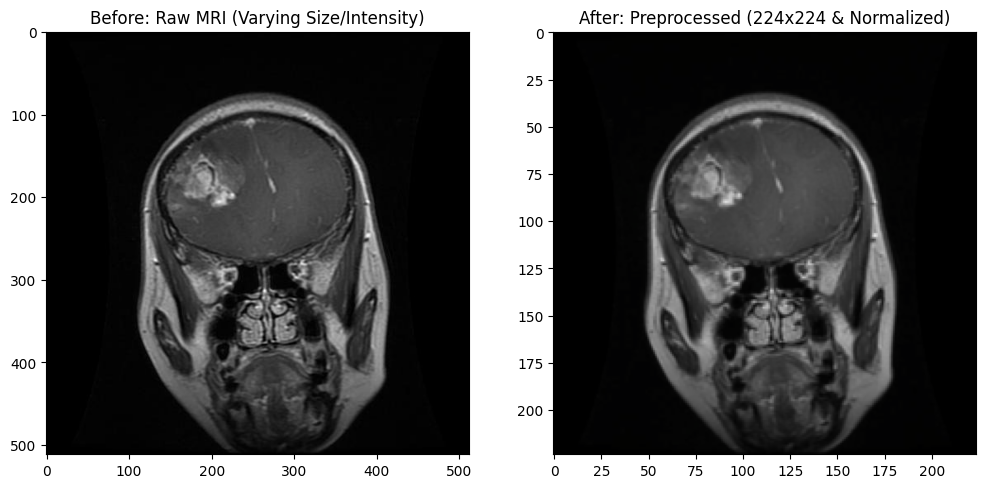

In [16]:
def plot_preprocessing_effect(dataset_path):
    from PIL import Image
    raw_img = Image.open(train_dataset.imgs[0][0]) # Load one raw file

    # Process it using our transform
    processed_img, _ = train_dataset[0]
    processed_img = processed_img.permute(1, 2, 0).numpy()
    processed_img = (processed_img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(raw_img)
    plt.title("Before: Raw MRI (Varying Size/Intensity)")

    plt.subplot(1, 2, 2)
    plt.imshow(np.clip(processed_img, 0, 1))
    plt.title("After: Preprocessed (224x224 & Normalized)")
    plt.savefig("figure_3_preprocessing.png")
    plt.show()

plot_preprocessing_effect('brain_data/Training')


**Training History (Loss & Accuracy)**

In [18]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss Curve
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    ax1.set_title('Training vs. Validation Loss')
    ax1.legend()

    # Accuracy Curve
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Acc')
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Acc')
    ax2.set_title('Training vs. Validation Accuracy')
    ax2.legend()

    plt.savefig("figure_4_history.png")
    plt.show()


 **Advanced Evaluation (Confusion Matrix & ROC)**

In [20]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_advanced_metrics(model, loader, classes):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs, _ = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    # --- Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.savefig("figure_5_cm.png")

    # --- ROC / AUC ---
    plt.figure(figsize=(10, 8))
    all_probs = np.array(all_probs)
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(np.array(all_labels) == i, all_probs[:, i])
        plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {auc(fpr, tpr):.3f})')
    plt.plot(,, 'k--')
    plt.title("Multiclass ROC Curves")
    plt.legend()
    plt.savefig("figure_6_roc.png")

plot_advanced_metrics(model, test_loader, classes)


SyntaxError: invalid syntax (ipython-input-1538146087.py, line 29)